In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix
!pip install unidecode
from unidecode import unidecode
from nltk.corpus import stopwords 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

In [25]:
%%bash
mkdir ~/.kaggle
mv kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
cat ~/.kaggle/kaggle.json 

{"username":"kristinp9","key":"2b9a20aef527a95c59db004baa4642f5"}

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


In [26]:
!kaggle datasets download -d crowdflower/twitter-airline-sentiment

twitter-airline-sentiment.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip twitter-airline-sentiment.zip

Archive:  twitter-airline-sentiment.zip
replace Tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
df = pd.read_csv("Tweets.csv", dtype=str)
df.head()

In [ ]:
df.columns

In [ ]:
df.shape

In [ ]:
df['count'] = df['text'].str.count(' ') + 1
df.head()

In [ ]:
df['text'] = df['text'].str.replace(r'#\w+', '').str.replace(r'http.?://[^\s]+[\s]?', '').str.replace(r'@\w+', '').str.replace(r'"\w+', '').str.replace('\d+', '')
df["text"] = df['text'].str.lower()
df.head()

In [ ]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('airline_sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='airline_sentiment', height=5, hue='airline_sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

In [ ]:
show_dist(df, 'count')

In [12]:
import re
!pip install nltk
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Quitamos palabras que no tengan valor semántico como artículos, preposiciones, conectores. Quitamos usuario mencionado con @, quitamos links y urls publicadas

In [13]:
class CleanText(BaseEstimator, TransformerMixin):
    @staticmethod
    def _remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)

    @staticmethod
    def _remove_urls(input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)

    @staticmethod
    def _remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        whitelist = [["n't", "not", "no"]]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words)

    @staticmethod
    def _remove_digits(input_text):
        return re.sub('\d+', '', input_text)

    @staticmethod
    def _to_lower(input_text):
        return input_text.lower()
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self._remove_mentions).apply(self._remove_urls).apply(self._remove_stopwords).apply(self._remove_digits).apply(self._to_lower)
        return clean_X
    

ct = CleanText()
sr_clean = ct.fit_transform(df.text)
sr_clean.sample(5)

4472    wife's rr pts expired days ago, planning fligh...
4628                          days ago. miss warm weather
2016                         one lady helping  us luggage
5978    rude customer svc, accommodate earlier flight ...
8694                                   always pleasure ☺️
Name: text, dtype: object

## Palabras más frecuentes

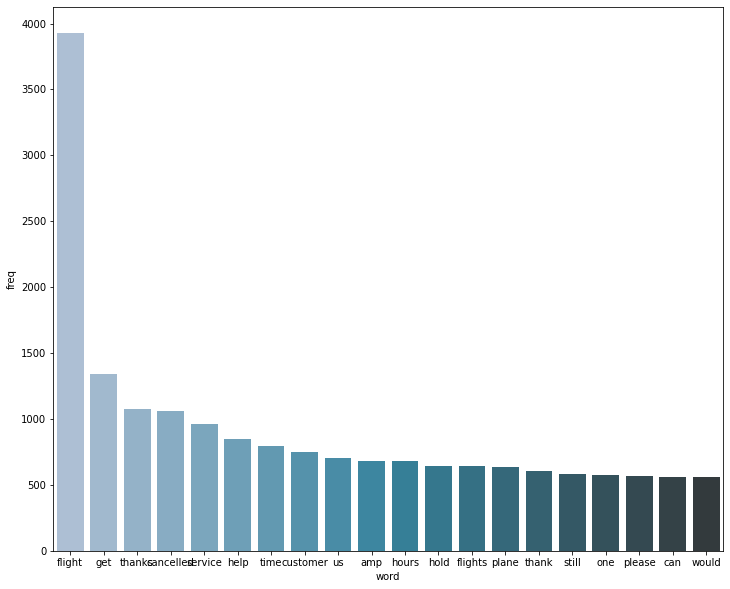

In [14]:
import collections

cv = CountVectorizer()
bow = cv.fit_transform(sr_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [15]:
df=df.sample(frac=0.4)
df.shape

(5856, 16)

In [16]:
df.airline_sentiment.value_counts() #positivos y neutrales en una clase para hacer observaciones bianarias

negative    3663
neutral     1220
positive     973
Name: airline_sentiment, dtype: int64

In [17]:
df['airline_sentiment'] = df['airline_sentiment'].replace({'neutral':'positive'})
df.airline_sentiment.value_counts()

negative    3663
positive    2193
Name: airline_sentiment, dtype: int64

## Modelo TfidVerctorizer
### Esto además de la frecuencia tiene en cuenta el peso de la palabra si figura menos veces

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = stopwords.words('english');

Train,Test=train_test_split(df[['text','airline_sentiment']],stratify=df['airline_sentiment'],random_state=3);

Train.reset_index(drop=True,inplace=True);
Test.reset_index(drop=True,inplace=True);

tvectorizer=TfidfVectorizer(strip_accents='unicode',stop_words=stop_words, ngram_range= (1,2));
tvectorizer.fit(Train['text']);

X_train=tvectorizer.fit_transform(Train['text']);
X_test=tvectorizer.transform(Test['text']);

y_train=Train['airline_sentiment'];
y_test=Test['airline_sentiment'];

NBC=MultinomialNB();

NBC.fit(X_train.todense(),Train['airline_sentiment']);

test_pred=NBC.predict(X_test.todense());

print('Training set shape:',X_train.shape)

print('\nTest Accuracy:',accuracy_score(Test['airline_sentiment'],test_pred))

print('\nConfusion Matrix:\n',confusion_matrix(Test['airline_sentiment'],test_pred))


Training set shape: (4392, 33275)

Test Accuracy: 0.7151639344262295

Confusion Matrix:
 [[906  10]
 [407 141]]


In [19]:
skf=StratifiedKFold(n_splits=3,random_state=0,shuffle=True);

params={'alpha':np.arange(0.1,2,0.1)};
GS_CV=GridSearchCV(MultinomialNB(),params,cv=skf,verbose=1,n_jobs=-1);
GS_CV.fit(X_train,y_train);
print('best score:',GS_CV.best_score_)
print('best params:',GS_CV.best_params_)

best_model=GS_CV.best_estimator_;
best_model.fit(X_train,y_train); # entrenamos en todo el training set

print('\nTest set:\n')

test_pred=best_model.predict(X_test);

print('accuracy:',accuracy_score(Test['airline_sentiment'],test_pred))

print('\nconfusion:\n',confusion_matrix(Test['airline_sentiment'],test_pred))

Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


best score: 0.765255009107468
best params: {'alpha': 0.2}

Test set:

accuracy: 0.7793715846994536

confusion:
 [[884  32]
 [291 257]]


[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    1.6s finished


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Términos representativos de negativos:

['worst' 'flight cancelled' 'hours' 'flight delayed' 'rude' 'without'
 'unacceptable' 'hold' 'ridiculous' 'delayed' 'hold hours' 'call back'
 'mins' 'hung' 'late flightr' 'hour' 'hr' 'suck' 'stranded' 'stuck' 'hrs'
 'almost' 'horrible' 'flightled flight' 'hour delay' 'hate' 'worse'
 'hours late' 'lose' 'sit' 'terrible' 'luggage' 'counting' 'communication'
 'waiting' 'missed' 'vacation' 'answer' '200' 'baggage claim' 'nothing'
 'line' 'never fly' 'worst customer' 'upset' 'experience ever' 'lack'
 'counter' 'tarmac' 'half' 'flighting flight' 'sitting plane' 'paid'
 'boarded' 'suitcase' 'minutes' 'fix' 'offered' 'hotel' 'whole' '30 min'
 'solution' 'miss connection' 'flighted' 'needed' 'error' 'late'
 'frustrated' 'cancelled flighted' 'refused' 'delay' 'system' 'waited'
 'worst airline' 'delayed hours' 'phone' 'delivered' 'awful' 'flightr'
 'wtf' 'claim' 'told' 'almost hour' 'attitude' 'two hours' 'crazy'
 'answers' 'tried' 'inconvenience' 'hang' 't

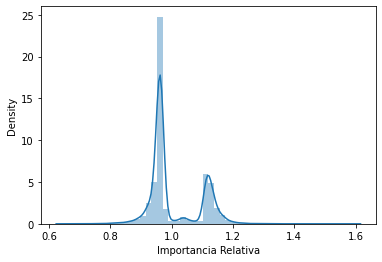

In [20]:
relative_importance=best_model.feature_log_prob_[0]/best_model.feature_log_prob_[1];
#relative_importance < 1 implica que
# el coeficiente asignado en la clase 0 es mayor que en la clase 1 y vicevera

sns.distplot(relative_importance)
plt.xlabel('Importancia Relativa')

features=np.array(tvectorizer.get_feature_names());

indices=np.argsort(relative_importance);

print('Términos representativos de negativos:\n')
print(features[indices[:100]])

print('\nTérminos representativos de neutrales/positivos:\n')
print(features[indices[-100:]])


## Modelo CountVectorizer

In [21]:
stop_words = stopwords.words('english');

Train,Test=train_test_split(df[['text','airline_sentiment']],stratify=df['airline_sentiment'],random_state=3);

Train.reset_index(drop=True,inplace=True);
Test.reset_index(drop=True,inplace=True);

vectorizer=CountVectorizer(strip_accents='unicode',stop_words=stop_words, ngram_range= (1,2));
vectorizer.fit(Train['text']);

X_train=vectorizer.fit_transform(Train['text']);
X_test=vectorizer.transform(Test['text']);

y_train=Train['airline_sentiment'];
y_test=Test['airline_sentiment'];

NBC=MultinomialNB();

NBC.fit(X_train.todense(),Train['airline_sentiment']);

test_pred=NBC.predict(X_test.todense());

print('Training set shape:',X_train.shape)

print('\nTest Accuracy:',accuracy_score(Test['airline_sentiment'],test_pred))

print('\nConfusion Matrix:\n',confusion_matrix(Test['airline_sentiment'],test_pred))


Training set shape: (4392, 33275)

Test Accuracy: 0.7793715846994536

Confusion Matrix:
 [[879  37]
 [286 262]]


In [22]:
skf=StratifiedKFold(n_splits=3,random_state=0,shuffle=True);

params={'alpha':np.arange(0.1,2,0.1)};
GS_CV=GridSearchCV(MultinomialNB(),params,cv=skf,verbose=1,n_jobs=-1);
GS_CV.fit(X_train,y_train);
print('best score:',GS_CV.best_score_)
print('best params:',GS_CV.best_params_)

best_model=GS_CV.best_estimator_;
best_model.fit(X_train,y_train); # entrenamos en todo el training set

print('\nTest set:\n')

test_pred=best_model.predict(X_test);

print('accuracy:',accuracy_score(Test['airline_sentiment'],test_pred))

print('\nconfusion:\n',confusion_matrix(Test['airline_sentiment'],test_pred))

Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


best score: 0.7727686703096538
best params: {'alpha': 1.3000000000000003}

Test set:

accuracy: 0.7739071038251366

confusion:
 [[890  26]
 [305 243]]


[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    0.7s finished


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Términos representativos de negativos:

['hours' 'worst' 'flight cancelled' 'hold' 'rude' 'delayed'
 'flight delayed' 'late flightr' 'without' 'hour' 'stuck' 'hrs'
 'unacceptable' 'ridiculous' 'mins' 'call back' 'waiting' 'hr' 'luggage'
 'hold hours' 'missed' 'hung' 'stranded' 'flightled flight' 'almost'
 'line' 'worse' 'flighted' 'late' 'cancelled flighted' 'flightr' 'hotel'
 'communication' 'horrible' 'hours late' 'cancelled' 'minutes' 'tarmac'
 'sit' 'system' 'phone' 'told' 'delay' '200' 'hour delay' 'nothing'
 'answer' 'tried' 'min' 'vacation' 'terrible' 'baggage claim' 'claim'
 'fix' 'flightled' 'bags' 'cancelled flightled' 'awful' 'half' 'counting'
 'lack' 'counter' 'paid' '10' '30 min' 'suck' 'upset' 'error' 'needed'
 'call' 'waited' 'sitting' 'seriously' 'never' 'whole' 'lose' 'offered'
 'boarded' 'worst customer' 'miss connection' 'delivered' 'sitting plane'
 'still' 'lost' 'said' 'cancelled flight' 'saying' 'plane' 'agents'
 'frustrated' 'wtf' 'delayed hours' 'suitcase' 'hate

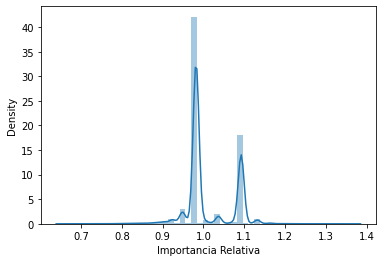

In [23]:
relative_importance=best_model.feature_log_prob_[0]/best_model.feature_log_prob_[1];
#relative_importance < 1 implica que
# el coeficiente asignado en la clase 0 es mayor que en la clase 1 y vicevera

sns.distplot(relative_importance)
plt.xlabel('Importancia Relativa')

features=np.array(vectorizer.get_feature_names());

indices=np.argsort(relative_importance);

print('Términos representativos de negativos:\n')
print(features[indices[:100]])

print('\nTérminos representativos de neutrales/positivos:\n')
print(features[indices[-100:]])
